## Object counting and instance segmentation with image-level supervision
### Demo: Object counting in COCO Dataset

In [7]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# from nest import modules, run_tasks
import matplotlib.pyplot as plt
import random
import xml.etree.ElementTree as ET
from collections import OrderedDict
from PIL import Image
import cv2
# from scipy.misc import imresize
from pycocotools.coco import COCO
from termcolor import colored

### Counting evaluation functions

In [2]:
from utils.utils import mrmse, rel_mrmse
from train_utils.datasets import image_transform

### Inference setup

In [3]:
nms = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck',
       'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
       'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
       'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
       'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
       'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
       'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa',
       'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse',
       'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
       'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [4]:
# object categories
# coco_path='/raid/xiaoke/MSCOCO/coco'
# cocoGt=COCO(coco_path+'/annotations/instances_val2014.json')
# image_ids=cocoGt.getImgIds()

# catids=cocoGt.getCatIds()
# cats = cocoGt.loadCats(catids)
# nms=[cat['name'] for cat in cats]

# image pre-processor
image_size = 448
transformer = image_transform(
    image_size = [image_size, image_size],
    augmentation = dict(),
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])

### Load model weights

In [5]:
from models.backbone import fc_resnet50
from models.PRM import peak_response_mapping

backbone = fc_resnet50(channels=240, pretrained=False)
model = peak_response_mapping(backbone, 
                            enable_peak_stimulation=True,
                            peak_stimulation='addedmodule5',
                            sub_pixel_locating_factor=1)

# loaded pre-trained weights
model = nn.DataParallel(model)
state = torch.load('./weights/coco14.pt')
model.load_state_dict(state['model'])
model = model.module.cuda()

<function PeakResponseMapping._median_filter at 0x0000026F4AF36790>
addedmodule5
enable_peak_stimulation on


### Load demo images from COCO dataset

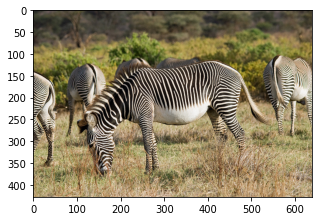

In [8]:
# change the idx to test different samples

idx = 0
raw_img = Image.open('./demo/coco/sample%d.jpg'% idx).convert('RGB')
input_var = transformer(raw_img).unsqueeze(0).cuda().requires_grad_()
# plot raw image
plt.figure(figsize=(5,5))
plt.imshow(raw_img)

In [9]:
## predict count
model = model.eval()
confidence, density_map, _ = model(input_var, 1)
count_den = F.adaptive_avg_pool2d(density_map, 1).squeeze(2).squeeze(2).detach().cpu().numpy()[0]
density_map = density_map.squeeze().detach().cpu().numpy()
confidence = confidence.cpu().detach().numpy()
confidence[confidence < 0] = 0
confidence = confidence[0]
confidence[confidence > 0] = 1
count = np.round(confidence * count_den)

print('***************************')
print('Object count in the image:')
for index in range(len(nms)):
    if count[index]:
        print(colored('    [class_idx: %d] %s (%.2f)' % (index, nms[index], count[index]), 'blue'))


***************************
Object count in the image:
    [class_idx: 22] zebra (6.00)
